=== training with all data (randGen) ===
# train_acc: 0.9449941792782305
# test_acc: 0.9327208061647896
=== training with all data (semiRand) ===
# train_acc: 0.9166463563246405
# test_acc: 0.8918197984588027
=== training with all data (aNotA) ===
# train_acc: 0.9038701622971286
# test_acc: 0.9096028452874926


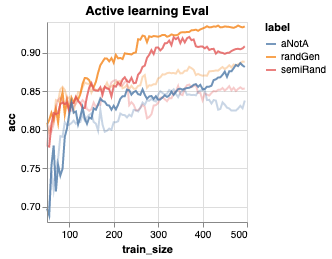

In [44]:
%matplotlib inline
import json
from pprint import pprint
import copy
import sys

import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel

# use seaborn plotting defaults
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from vega import VegaLite

from pykliep import DensityRatioEstimator 

colors = ["r", "g", "b", "orange"]

def get_feature(vis):
    """Given a vis json object, parse its feature """
    def parse_soft_rule(rule):
        head = rule[:rule.index("(")]
        body = rule[rule.index("(") + 1: rule.index(")", -1)]
        literals = body.strip().split(",")
        return head, literals

    draco_facts = vis["draco"]
    if not isinstance(vis["draco"], (list,)):
        draco_facts = json.loads(vis["draco"])
    
    facts = [x for x in draco_facts if x.startswith("soft")]
    feature = {}
    for r in facts:
        h, l = parse_soft_rule(r)
        if len(l) > 1:
            rname = h + "-" + l[0] + "-" + l[1]
        else:
            rname = h + "-" + l[0]
        if rname not in feature:
            feature[rname] = 0
        feature[rname] += 1
        
    return feature

def get_pair_feature(pair):
    """Get the feature of a pair that will be used in active learning"""
    # flip the <, >
    flip = np.random.choice([0, 1])    
    if pair["comparator"] not in [">", "<"]:
        return None, None
    label = -1 if pair["comparator"] == "<" else 1
    left_facts = get_feature(pair["left"])
    right_facts = get_feature(pair["right"])
    combined = copy.copy(left_facts)
    for k, v in right_facts.items():
        if k not in combined:
            combined[k] = 0
        combined[k] -= v
    if flip == 1:
        for k, v in combined.items():
            combined[k] = -v
        label = -label
    return combined, label

def plot_svc_decision_function(model, ax=None, plot_support=False):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    
def feature_selection(X_train, y_train, X_test, y_test, all_features= None):
    """train and eval the model using data X, y"""
    model = LinearSVC(fit_intercept=0, C=0.01, penalty="l1", dual=False)
    
    model.fit(X_train, y_train)
    print("# training acc: {}".format(model.score(X_train, y_train)))
    print("# testing  acc: {}".format(model.score(X_test, y_test)))
    
    print("# Feature selection result:")
    model = SelectFromModel(model, prefit=True)
    if all_features is not None:
        for mask, f in zip(model.get_support(), all_features):
            if mask:
                print(f)

def active_learn(raw_model, X_train, y_train, X_test, y_test, sample_func="entropy", stop_size=500):
    """active learning loop
        Returns a list [(i, acc), ...] 
            where i is the training size and acc is the dev accuracy
    """
    
    model = CalibratedClassifierCV(raw_model, cv=5)
        
    X_label, X_pool = X_train[:50], X_train[50:]
    y_label, y_pool = y_train[:50], y_train[50:]
        
    X_label, y_label = list(X_label), list(y_label)
    X_pool, y_pool = list(X_pool), list(y_pool)
    
    sample_size = 5
    
    train_size = []
    acc_list = []
    while len(X_pool) > 0 and len(X_label) < stop_size:
        
        model.fit(X_label, y_label)
        
        acc = model.score(X_test, y_test)
        acc_list.append(acc)
        train_size.append(len(X_label))

        # different sample function to obtain new data
        if sample_func == "entropy":
            # entropy based sampling
            prob_vals = model.predict_proba(X_pool)
            entropy_uncertainty = (-prob_vals * np.log2(prob_vals)).sum(axis=1)
            selections = (np.argsort(entropy_uncertainty)[::-1])[:sample_size]
        elif sample_func == "margin":
            # entropy based sampling
            prob_vals = model.predict_proba(X_pool)
            rev = np.sort(prob_vals, axis=1)[:, ::-1]
            values = rev[:, 0] - rev[:, 1]
            selections = np.argsort(values)[:sample_size]
        elif sample_func == "random":
            selections = np.random.choice(list(range(len(X_pool))), sample_size)

        X_label = X_label + [v for i,v in enumerate(X_pool) if i in selections]
        y_label = y_label + [v for i,v in enumerate(y_pool) if i in selections]
        
        X_pool = [v for i,v in enumerate(X_pool) if i not in selections]
        y_pool = [v for i,v in enumerate(y_pool) if i not in selections]
    
    return [(x, y) for x, y in zip(train_size, acc_list)]

            
def load_pairs_from_file(fname, pair_limit):
    with open(fname, "r") as f:
        pairs = json.load(f)
        pairs = pairs[:pair_limit if len(pairs) > pair_limit else len(pairs)]
        data = []
        for p in pairs:
            feature, label = get_pair_feature(p)
            if feature is None:
                continue
            data.append((feature, label))
    return data
        
def eval_active_learn(datafile, test_datafile, maximum_pairs_used=5000, label=""):
    """train and evalute the learning result """
    data = load_pairs_from_file(datafile, maximum_pairs_used) #+ load_pairs_from_file("structured_labeled_pairs_large.json", pair_limit=5000)
    test_data = load_pairs_from_file(test_datafile, pair_limit=5000)# + load_pairs_from_file("test-splits/chunk_3.json", pair_limit=5000)
    
    all_features = list(set([k for p in data for k in p[0].keys()]))
    all_features = list(set([k for p in data + test_data for k in p[0].keys()]))
        
    X_test = np.array([[(p[0][feature_name] if feature_name in p[0] else 0) 
                        for feature_name in all_features] for p in test_data])
    y_test = np.array([p[1] for p in test_data])

    X_train = np.array([[(p[0][feature_name] if feature_name in p[0] else 0) 
                         for feature_name in all_features] for p in data])
    
    y_train_raw = [p[1] for p in data]
    
#     kliep = DensityRatioEstimator()
#     kliep.fit(X_train, X_test) # keyword arguments are X_train and X_test
#     weights = kliep.predict(X_train)
    
    y_train = np.array(y_train_raw)        
    
    print("=== training with all data ({}) ===".format(label))
    model = LinearSVC(fit_intercept=0, max_iter=5000)
    model.fit(X_train, y_train)
    print("# train_acc: {}".format(model.score(X_train, y_train)))
    print("# test_acc: {}".format(model.score(X_test, y_test)))
    
    # training with active learning
    model = LinearSVC(fit_intercept=0, max_iter=5000)
    act_dev_acc = active_learn(model, X_train, y_train, X_test, y_test, sample_func="entropy")
    rand_dev_acc = active_learn(model, X_train, y_train, X_test, y_test, sample_func="random")

    act_dev_acc = [{"train_size": x, 
                    "acc": y, 
                    "label": label,
                    "active": True} for x, y in act_dev_acc]
    rand_dev_acc = [{"train_size": x, 
                    "acc": y, 
                    "label": label,
                    "active": False} for x, y in rand_dev_acc]
    
    return act_dev_acc + rand_dev_acc

np.random.seed(9984)

plot_data = []

#test_datafile = "structured_labeled_pairs_no_min.json"#
test_datafile = "test-splits/chunk_3.json"
#test_datafile = "test_pairs_top2.json"

plot_data += eval_active_learn("test-splits/chunk_2.json", test_datafile, label="randGen")
#plot_data += eval_active_learn("struct_labeled_pairs_no_min.json", test_datafile, label="noMin")
#plot_data += eval_active_learn("structured_labeled_pairs_large.json", test_datafile, label="structGen")
#plot_data += eval_active_learn("structured_choose_dim_labeled_pairs.json", test_datafile, label="structGenSmall")

plot_data += eval_active_learn("semi-random.json", test_datafile, label="semiRand")
plot_data += eval_active_learn("a-not-a-large.json", test_datafile, label="aNotA")

VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "title": { "text": "Active learning Eval" },
  "data": { "values": plot_data },
  "mark": "line",
  "encoding": {
    "x": {"field": "train_size", "type": "quantitative"},
    "y": {"field": "acc", "type": "quantitative", "scale": {"zero": False}},
    "color": {"field": "label", "type": "nominal"},
    "strokeOpacity": {"field": "active", "type": "nominal"}
  }
})